### Note: This project is intended as a portofolio purpose. All of the answers are not 100% correct. It is to showcase my understanding on how to use Machine Learning to solve problems.

# Question 1 Background

Every year, around 7 million people die prematurely because of air pollution. It's one of the biggest environmental health threats we face, according to the WHO. If we want to tackle this problem, we need reliable ways to track pollutant levels in cities.

On the other hand, good monitoring equipment is very expensive. A single reference-grade sensor that measures carbon monoxide, nitrogen oxides, or particulate matter can easily run into the thousands of pounds. Sure, you can get cheaper sensors, but they're far less reliable.

To support the decision-making, a compact, low-cost air-quality monitor design is needed. The device will use a small set of electrochemical and meteorological sensors to estimate the true concentration of carbon monoxide in the atmosphere. The space and budget is limited so we need to be strategic in choosing sensors.

## Business Objective

1. To construct and compare regression models which predict CO concentration from sensors and environments
2. Measure the trade-off of the accuracy and hardware-cost, and choose which sensor(s) should be bought given the limited budget
3. Recommend stakeholders for the most cost-effective design

## Dataset Description

We will use the data from the paper De Vito, S., Massera, E., Piga, M., Martinotto, L., & Di Francia, G. (2008). On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, collected in an Italian city in 2004–2005.

Here's the table explaining the features:

| Variable | Description | Typical Range |
|----------|-------------|---------------|
| PT08.S1(CO) | Tin oxide sensor response (ppm) | 300–1800 |
| PT08.S2(NMHC) | Non-methane hydrocarbon sensor | 400–2000 |
| PT08.S3(NOx) | Nitrogen oxide sensor | 400–2000 |
| PT08.S4(NO2) | Nitrogen dioxide sensor | 400–2000 |
| PT08.S5(O3) | Ozone sensor | 400–2000 |
| T | Temperature (°C) | –10 – 40 |
| RH | Relative humidity (%) | 0 – 100 |
| AH | Absolute humidity | 0 – 50 |
| NOx(GT) | Reference NOₓ concentration | 0 – 600 |
| NO2(GT) | Reference NO₂ concentration | 0 – 250 |
| C6H6(GT) | Benzene concentration (µg/m³) | 0–15 |
| CO(GT) | Ground-truth CO concentration (target) | 0 – 10 |

# <ins> Data Understanding </ins>

## Homework Part A & B

Note: after analysing the homework question and went through it, I notice part A and B can be done together (with some of part A later will be implemented in part C)


#### PART A
Report percentage of missing features and propose a strategy to handle the missing data with the reason of choosing the method.

#### PART B
Plot a correlation matrix and learn the data distribution between features and the target. Give remarks regarding strong correlation and potential multicollinearity.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

#I'm using my local directory
air_data = pd.read_csv('~/Machine Learning/Assignment 2025/air_data/q1.csv')
#I'll arrange columns so that it's similar to the instruction table (not necessary)
table_order = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
               'PT08.S5(O3)', 'T', 'RH', 'AH', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'CO(GT)']
air_data = air_data[table_order]
#check data size
print(air_data.shape)
#overview of the data, I get 3 rows to save space
air_data.head(3)

(7674, 12)


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NOx(GT),NO2(GT),C6H6(GT),CO(GT)
0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,166.0,113.0,11.9,2.6
1,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,103.0,92.0,9.4,2.0
2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,131.0,114.0,9.0,2.2


In [2]:
#For EACH FEATURE, report the percentage of missing entries (PART A 1.1)

#exclude target column
air_data_features = air_data.drop(['CO(GT)'], axis=1)

#missing data dataframe
missing_data = pd.DataFrame({'Missing_Count': air_data_features.isnull().sum(), 
                             'Missing_Percentage': (air_data_features.isnull().sum() / len(air_data_features)) * 100})

#The percentage format will rounded by 2 decimals and added % symbol
missing_data['Missing_Percentage_Per_Feature'] = missing_data['Missing_Percentage'].round(2).astype(str) + '%'
missing_data = missing_data.sort_values('Missing_Percentage', ascending=False)
missing_data.drop(['Missing_Percentage'],axis=1,inplace=True)
missing_data #show the data

,Missing_Count,Missing_Percentage_Per_Feature
NO2(GT),416,5.42%
NOx(GT),413,5.38%
PT08.S1(CO),330,4.3%
PT08.S2(NMHC),330,4.3%
PT08.S3(NOx),330,4.3%
PT08.S4(NO2),330,4.3%
PT08.S5(O3),330,4.3%
T,330,4.3%
RH,330,4.3%
AH,330,4.3%


In [3]:
#Double check whether there's a row of data with every feature missing except the target
all_features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
               'PT08.S5(O3)', 'T', 'RH', 'AH', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
missing_rows_3 = air_data[air_data[all_features].isnull().all(axis=1)]
print(f"Total of data missing all features except target: {missing_rows_3.shape[0]}")
missing_rows_3.head(4)

Total of data missing all features except target: 13


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NOx(GT),NO2(GT),C6H6(GT),CO(GT)
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7


I choose to drop these rows since it will just add noise to the data. Moreover since data imputation is done after train test split and I choose KNN imputer to be used later on. It won't be able to calculate proper distances with all NaN values.

In [4]:
#drop the rows where all of the features are NaN
air_data = air_data.dropna(subset=all_features, how='all')

#Also, here's the reason why I choose KNN Imputer. See the correlation of the data using heatmap package
corr = air_data.corr()

Note: Using the normal corr() function will only return table which is quite difficult to see, in this assignment I will use heat map from seaborn library to illustrate it better.

The documentation can be seen here: https://seaborn.pydata.org/generated/seaborn.heatmap.html [1]

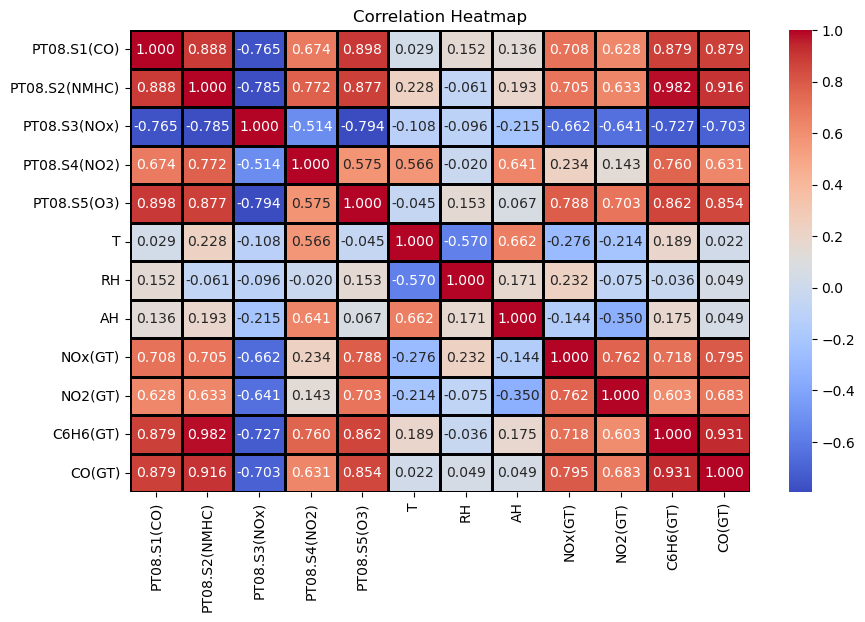

In [5]:
#Illustrate correlation with plot or pairs plot (Part B 1.1) => Answer
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(corr, linewidths=1,linecolor='black', annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Heatmap")
plt.show()

<ins>Part B 1.2: study the distributions of the main features and the target and comment on any presence of strong correlations and potential
multicollinearity<ins>

Notice that, the target feature has high positive correlation with multiple features which are: PT08.S1(CO), PT08.S2(NMHC), PT08.S4(NO2), PT08.S5(O3), NOx(GT), NO2(GT) and C6H6(GT). It also has strong negative correlation with PT08.S3(NOx), which is quite surprising since the paper where the dataset is based from have a result in which NOx has positive correlation with CO and C6H6. Additionally, the target feature has low correlation with T, RH and AH.

However, from the correlation matrix, it is also shown that feature such as PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3), NOx(GT), NO2(GT) and C6H6(GT) are highly correlated with each other which is a sign of multicollinearity [2]

<ins>Part A 1.2: Propose a strategy for handling the missing data and implement it<ins>

The 13 rows which have all null values in all features except target can be dropped since it will negatively affect our model. Also, referring to the correlation analysis above, using either Mean or Median imputation is not suitable. Because mean and median imputation will fill out the missing value with the same number all over the missing place which can affect the natural state of data correlation and give high bias to the model prediction.

The imputation that we can impelement in this one is KNN Neighbors imputation. This imputation will fill in missing data with using k-Nearest Neighbors which means it will fill in the missing value using the mean value from n_neighbors (the parameter we set) found in the air_data, thus preserving the correlation. However, this KNN imputer is implemented on the training set according to the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html. Thus, we will do it later during the train-test split part.[3]

#### PART C

Randomly divide the data into train-test set with 80:20 ratio. Then, fit an Ordinary Least Square Model (OLS) with all features (recommended to use statmodels library). Provide the summary of the model and draw conclusion. Make a comment regarding some coefficients which have large magnitude or big p-values.

In [6]:
#The code below is referenced from worksheet1  [4]

import statsmodels.api as sm
from sklearn.impute import KNNImputer

#Split the data randomly into a training set (80%) and test set (20%)
#Fit an ordinary least squares model with ALL THE FEATURES. (Part C 1.1)

features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
               'PT08.S5(O3)', 'T', 'RH', 'AH', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
X = air_data[features]
y = air_data['CO(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #splitted to 80:20

# Impute and fit model (this is for part A too since it asks to implement it)
knn_impute = KNNImputer(n_neighbors=5) #I'm using the default 5 neighbors
X_train_imputed = pd.DataFrame(knn_impute.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#use transform for test data because the parameter is learned from fit_transform in training data
X_test_imputed = pd.DataFrame(knn_impute.transform(X_test), columns=X_test.columns,index=X_test.index)

X_train_imputed = sm.add_constant(X_train_imputed)
model = sm.OLS(y_train, X_train_imputed).fit()

#Provide a model summary and list significant variables. (Part C 1.2)
print(model.summary())

# Extract data from the model
model.rsquared

                            OLS Regression Results                            
Dep. Variable:                 CO(GT)   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     5031.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        06:48:34   Log-Likelihood:                -3877.0
No. Observations:                6128   AIC:                             7778.
Df Residuals:                    6116   BIC:                             7859.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1545      0.144     -7.996

np.float64(0.9004827430929241)

The model has good R-squared (0.9) which means it is a very good linear model. However, the condition number is extremely high (6.25e+04) which means that the model suffers from strong multicollinearity.

This can be seen when we compare C6H6(GT) and PT08.S2(NMHC). Both features are highly correlated with the target and with each other (corr: 0.982). However, C6H6(GT) is assigned a large positive coefficient (0.1080), while PT08.S2 is assigned a very small negative value of -0.0001. Due to multicollinearity, one of the feature looks redundant and the model is having difficulty to assign the value of which actually affecting the target. This uncertainty is also the reason PT08.S2 having a p-value of 0.523 even though it is a strong predictor (can be seen from its correlation to the target).

#### PART D

Fit ridge and lasso regressions with cross-validation to calibrate the regularisation parameter. Then, plot the coefficient paths as a function of the regularisation parameter (must be on log-scale and fit scaled features). Give opinion regarding the consequence of regularisation on multicollinearity and model interpretability.

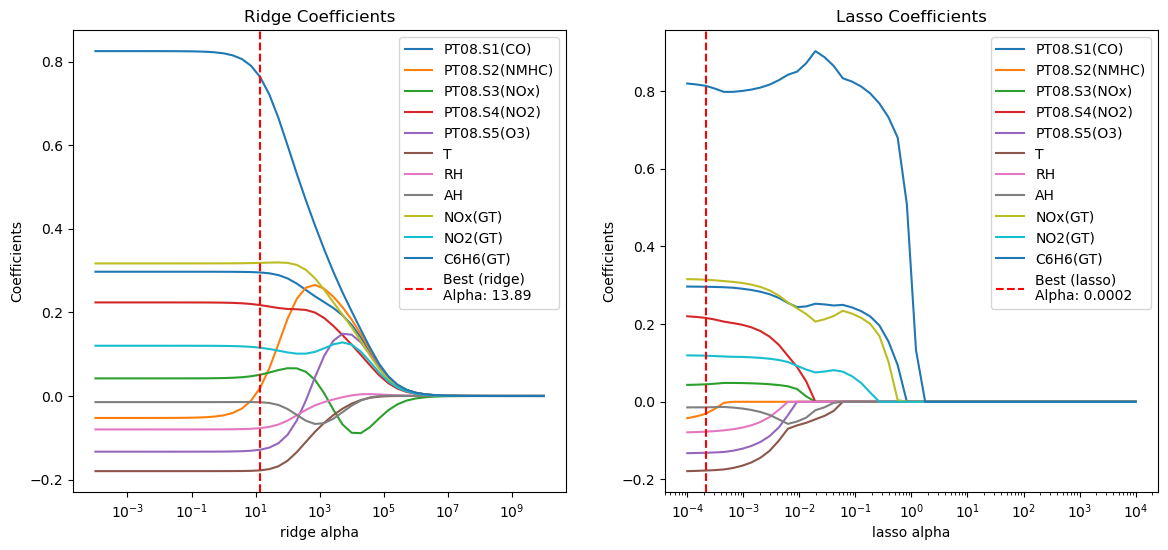

Best Ridge Alpha is 13.895 searched in 50 point of log space between 10⁻⁴ and 10¹⁰
Best Lasso Alpha is 0.0002 searched in 50 point of log space between 10⁻⁴ and 10⁴


In [7]:
#The code below is referenced from worksheet3 [5]

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import KFold

#since OLS question doesn't ask the data to be scaled, we will scale the data here in part D
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

#then we impute the data
X_train_imputed = pd.DataFrame(knn_impute.fit_transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_imputed = pd.DataFrame(knn_impute.transform(X_test_scaled), columns=X_test_scaled.columns,index=X_test_scaled.index)

#PART D 1.1
reg_alphas_ridge = np.logspace(-4, 10, 50) #logsclale
reg_alphas_lasso = np.logspace(-4, 4, 50)

#cross validation settings
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Cross-validated Ridge and Lasso models
ridge_cv_model = RidgeCV(alphas=reg_alphas_ridge, cv=cv)
ridge_cv_model.fit(X_train_imputed, y_train)
lasso_cv_model = LassoCV(alphas=reg_alphas_lasso, cv=cv)
lasso_cv_model.fit(X_train_imputed, y_train)

best_ridge_alpha = ridge_cv_model.alpha_
best_lasso_alpha = lasso_cv_model.alpha_

#list and for loop then append to list for ridge and lasso coefficient plotting purpose
co_ridge = []  #for holding ridge coefficients
co_lasso = [] #for holding lasso coefficients

for n in reg_alphas_ridge:
    ridge = Ridge(alpha=n)
    ridge.fit(X_train_imputed, y_train)
    co_ridge.append(ridge.coef_)

for n in reg_alphas_lasso:
    lasso = Lasso(alpha=n)
    lasso.fit(X_train_imputed, y_train)
    co_lasso.append(lasso.coef_)

#PART D 1.2

plt.figure(figsize=(14, 6))

#ridge
plt.subplot(1, 2, 1)
plt.plot(reg_alphas_ridge, co_ridge, label=features) #plot for ridge coefs
plt.xscale('log')
plt.xlabel('ridge alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients')
plt.axvline(x=best_ridge_alpha, color='red', linestyle='--', label=f'Best (ridge) \nAlpha: {best_ridge_alpha:.2f}')
plt.legend()

#lasso
plt.subplot(1, 2, 2)
plt.plot(reg_alphas_lasso, co_lasso, label=features) #plot for lasso coefs
plt.xscale('log')
plt.xlabel('lasso alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients')
plt.axvline(x=best_lasso_alpha, color='red', linestyle='--', label=f'Best (lasso) \nAlpha: {best_lasso_alpha:.4f}')
plt.legend()
#show plot for part D
plt.show()
#extra info for comments
print(f"Best Ridge Alpha is {ridge_cv_model.alpha_:.3f} searched in 50 point of log space between 10⁻⁴ and 10¹⁰")
print(f"Best Lasso Alpha is {lasso_cv_model.alpha_:.4f} searched in 50 point of log space between 10⁻⁴ and 10⁴")

<ins>PART D 1.3 (Comment)<ins>

The plots above show how each sensor changes as we increase the strength of the alpha. Since we have a strong multicollinearity problem in the earlier steps, the Ridge regression applies strong penalty at alpha 13.895 (using KFold cross val) to shrank the coefficients and stabilize the model. It will prevent it from overreacting to noise in the sensor data.

Since we have strong multicollinearity problem in the earlier steps, notice that the Ridge regression applies strong penalty at alpha 13.895 (using KFold cross val) to shrank the coefficients and stabilize the model, preventing it from overreacting to noise in the sensor data, in theory ridge regression doesn't reduce any of the coefficient to zero which means it's using all the features for its prediction. 

**Note: If we had not dropped the 13 rows of data in the earlier pre-processing, we would obtain a Ridge alpha in the range of 6 to 7. This suggests that the imputation of 13 rows performed by KNNImputer when all features are missing adds noise to the model, as KNNImputer struggles to find nearest neighbors when all features are absent. When the model contains noise, the Ridge alpha becomes smaller to add more flexibility to fit the model. Additionally, using different K-Fold cross-validation settings or cv parameters directly can produce different results.**

On the other side, the Lasso regression alpha is extremely small at 0.0002. Because Lasso technically can be used to select the best features, this small alpha value indicates that the model still needs to retain all sensors to achieve the best accuracy due to multicollinearity. This is not cost-effective because it does not eliminate any sensors to save costs. If we want to save money, increasing the alpha in the Lasso regression might help with the cost of accuracy.

#### PART E

Fit a kernel ridge regression (KRR) model using a polynomial with degree of 2. Make a comment whether the predictive performance increase, if yes, why it happened and vice versa.

In [8]:
#The code below is referenced from worksheet 5 [6]

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_krr(kernel, param_grid):

    # set up the pipeline
    pipe = Pipeline([
#        ("scaler", StandardScaler()), => we can remove it from the workbook 5 template since our data is already scaled and imputed
        ("krr", KernelRidge(kernel=kernel))
    ])

    #5 split CV
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    # merge grid into proper param names
    grid = {"krr__alpha": param_grid.get("alpha", [1.0])}
    for k, v in param_grid.items():
        if k != "alpha":
            grid[f"krr__{k}"] = v

    # Now run the grid search
    g = GridSearchCV(
        pipe, param_grid=grid, cv=cv,
        scoring="neg_root_mean_squared_error", n_jobs=None
    )
    # Run it
    g.fit(X_train_imputed, y_train)

    # Get the best model
    best = g.best_estimator_
    ytr = best.predict(X_train_imputed)
    yte = best.predict(X_test_imputed)
    
    return {
        "y_pred_test": yte,
        "best_params": g.best_params_,
        "train_rmse": rmse(y_train, ytr),
        "test_rmse": rmse(y_test, yte),
        "test_r2": r2_score(y_test, yte),
        "best_estimator": best
    }

In [9]:
#The code below is referenced from worksheet 5 [6]
res_poly_k = evaluate_krr("polynomial", {"alpha":[1], "degree":[2], "coef0":[1]})
print("Polynomial KRR:", res_poly_k["best_params"], "| Test RMSE:", round(res_poly_k["test_rmse"],3), "| R^2:", round(res_poly_k["test_r2"],3))
print(f"previous OLS R2 Score: {model.rsquared:.3f}")

Polynomial KRR: {'krr__alpha': 1, 'krr__coef0': 1, 'krr__degree': 2} | Test RMSE: 0.41 | R^2: 0.924
previous OLS R2 Score: 0.900


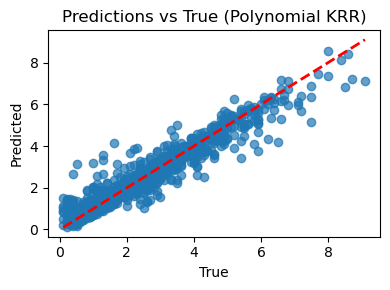

In [10]:
#The code below is referenced from worksheet 5 [6]
plt.figure(figsize=(4,3))
plt.scatter(y_test, res_poly_k['y_pred_test'], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predictions vs True (Polynomial KRR)")
plt.tight_layout()
plt.show()

Yes, using a polynomial kernel (Degree=2) improved the predictive performance. The $R^2$ score increased from 0.900 to 0.9232. This reveals the data contains non-linear patterns and feature interactions. By allowing the model to fit into a curve instead of a flat plane we are able to increase the predictive performance.

#### PART F

Now, fit the data using KRR with and RBF kernel. Calibrate the regularisation parameter and kernel by utilising grid search and cross validation.

In [11]:
#The code below is referenced from worksheet 5 [6]
res_rbf = evaluate_krr("rbf", {"alpha":[0.01,0.1,1.0], "gamma":[0.001,0.01,0.1,1.0]})
print("RBF KRR:", res_rbf["best_params"], "| Test RMSE:", round(res_rbf["test_rmse"],3), "| R^2:", round(res_rbf["test_r2"],3))

RBF KRR: {'krr__alpha': 0.1, 'krr__gamma': 0.1} | Test RMSE: 0.39 | R^2: 0.932


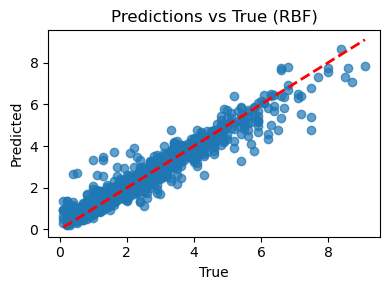

In [12]:
#The code below is referenced from worksheet 5 [6]
plt.figure(figsize=(4,3))
plt.scatter(y_test, res_rbf['y_pred_test'], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predictions vs True (RBF)")
plt.tight_layout()
plt.show()

Using the kernel ridge regression with an RBF kernel also improves the model performance. The $R^2$ score increased from 0.9232 (polynomial) to 0.933 (RBF). The model also has a low RMSE 0.385 which means the model is a better fit compared to it predecessors. 

#### PART G

For the models that we have fit the data into, create a performance metrics which shows in-sample and and the out-of-sample R2, MAE and RMSE. Make a comparison and the contrast to highlight the advantage and disadvantage model's performance and interpretability.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def six_perf_metrics(model, model_type, X_train_imputed, y_train, X_test_imputed, y_test):
    y_train_pred, y_test_pred = model.predict(X_train_imputed), model.predict(X_test_imputed)
    
    metrics = {'Model': model_type, 'In-Sample R2': r2_score(y_train, y_train_pred), 'Out-of-Sample R2': r2_score(y_test, y_test_pred),
        'In-Sample MAE': mean_absolute_error(y_train, y_train_pred),'Out-of-Sample MAE': mean_absolute_error(y_test, y_test_pred),
        'In-Sample RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)), 
        'Out-of-Sample RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
    
    return metrics

#I fit again OLS using the scikit learn here, because previously we use statmodels package and the data hasn't been scaled
ols_sk = LinearRegression()
ols_sk.fit(X_train_imputed, y_train)

models = [(ols_sk, "OLS"), (ridge_cv_model, "Ridge"), (lasso_cv_model, "Lasso"), (res_poly_k['best_estimator'], "KRR (Poly-2)"),
          (res_rbf['best_estimator'], "KRR (RBF)")]

score_list = []
for model, model_type in models:
    metrics = six_perf_metrics(model, model_type, X_train_imputed, y_train, X_test_imputed, y_test)
    score_list.append(metrics)

metrics_data = pd.DataFrame(score_list)
display(metrics_data.round(4))

,Model,In-Sample R2,Out-of-Sample R2,In-Sample MAE,Out-of-Sample MAE,In-Sample RMSE,Out-of-Sample RMSE
0,OLS,0.9007,0.9172,0.2823,0.2713,0.4550,0.4291
1,Ridge,0.9006,0.9169,0.2827,0.2721,0.4552,0.4299
2,Lasso,0.9007,0.9172,0.2822,0.2713,0.4551,0.4292
3,KRR (Poly-2),0.9131,0.9244,0.2645,0.2544,0.4256,0.4101
4,KRR (RBF),0.9353,0.9315,0.2279,0.2417,0.3674,0.3903


| MODELS   | PROS  |CONS       | 
| -------- | ------- | ------- |
| OLS  | Performance wise, the OLS model can prove it has strong predictive performance with $R^2 \approx 0.9172$ from out of sample data, proving the data has strong linearity. OLS can show coefficients to measure the impact of each features | The model suffers greatly from multicollinearity as seen from its condition number and makes some features redundant. |
| Ridge | Ridge regression model fixed the multicollinearity issue by shrinking coefficients, predictive performance is similar to OLS | It only shrinks the coefficients to near zero, which means it still keeps all features which is not very cost efficient    |
| Lasso    | Similar predictive performance with OLS and Ridge, but the lasso model could set redundant features coefficient to zero which is cost efficient (if alpha is large enough)| Since in the previous iteration our alpha is very small (0.0002), we are still don't know which features to select since the penalty from the alpha is very small. To save cost, we may need to increase the alpha and accept lower accuracy|
| Kernel Ridge Regression (Poly-2) | The model performs better with $R^2$ 0.924 from out of sample data, which means it can capture non-linear relationships within the data | While perform better, it's technically slower to train and doesn't add significant improvement. Moreover, same as OLS and Ridge, this model uses all features   |
| Kernel Ridge Regression (RBF)    | The model outperform every other model with $R^2$ 0.9315 and RMSE 0.3903 from out of sample data which shows the model now can capture local non-linear patterns | Despite having the best performance, KRR RBF is the slowest to train and still cost the same like most model since no feature is being dropped. Moreover, the model is not very easy to interpret since we can't easily identify which features affects predictions unlike the OLS, ridge and lasso |

#### PART H

Here's a detail of the cost for each sensors:

| Feature | Cost (£) |
| :--- | ---: |
| PT08.S1(CO) | 1,000 |
| PT08.S2(NMHC) | 800 |
| PT08.S3(NOx) | 700 |
| PT08.S4(NO2) | 700 |
| PT08.S5(O3) | 900 |
| T | 150 |
| RH | 150 |
| AH | 200 |
| NOx(GT) | 1,800 |
| NO2(GT) | 1,800 |
| C6H6(GT) | 2,500 |

A portable monitor has a budget limit of £4000. By utilising the lasso model, build a sequence of models corresponding to increasing total sensor cost. Then, for each models we need to record set of selected features, total cost and cross-validated RMSE on the training data.

Make a plot which highlight Cost vs. RMSE to illustrate the cost–accuracy by using a lasso path over a grid of regularisation parameters (e.g., $10^-6$ to 1). Make sure to do 5-fold CV RMSE, identify selected set, and compute total cost.

Here are two feasible designs:
* A low-cost monitor with cost ≤ £2500
* A high-performance monitor with cost ≤ £4000

Finally, measure the test-set RMSEs.

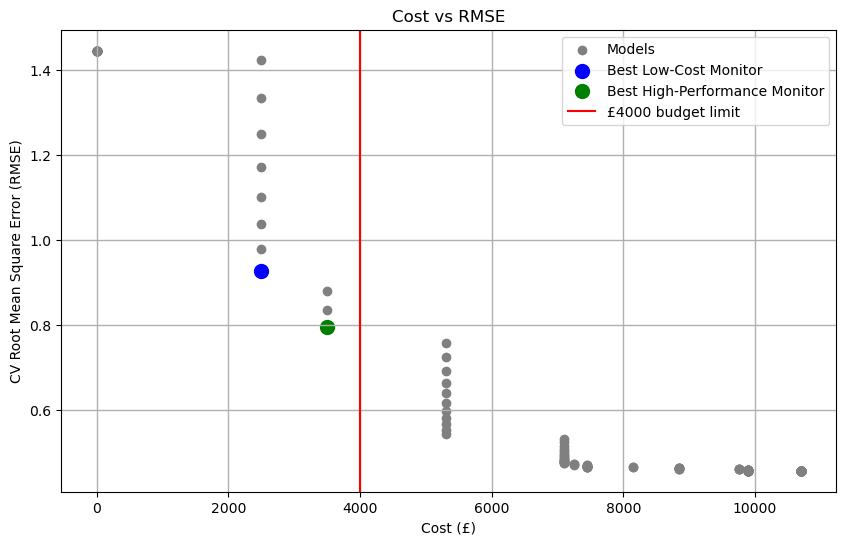

,Monitor Type,Total Cost (£),Selected Features,CV RMSE (Training Data),Test RMSE,R-squared
0,Low-Cost,2500,C6H6(GT),0.9274,0.962,0.5839
1,High-Performance,3500,"PT08.S1(CO), C6H6(GT)",0.7956,0.824,0.6947


In [14]:
#The code below is referenced and adapted from worksheet 3 [5]

from sklearn.model_selection import cross_val_score

#sensor price in dict
sensor_price = {'PT08.S1(CO)': 1000, 'PT08.S2(NMHC)': 800, 'PT08.S3(NOx)': 700, 'PT08.S4(NO2)': 700, 'PT08.S5(O3)': 900, 'T': 150, 
                'RH': 150, 'AH': 200, 'NOx(GT)': 1800, 'NO2(GT)': 1800, 'C6H6(GT)': 2500}

#regularisation parameters (e.g., 10⁻⁶ to 1)
reg_alphas = np.logspace(-6, 1, 200)
results = []

# we loop through lasso with different alphas and add to the results list
for n in reg_alphas:
    lasso = Lasso(alpha=n, random_state=42)
    
    #using 5 fold cross validation for this one
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    neg_mse = cross_val_score(lasso, X_train_imputed, y_train, cv=cv, scoring='neg_mean_squared_error')
    #inverse the negative since the default package use negative scoring (just for presentation, technically we don't need to do that)
    crossval_rmse = np.sqrt(-np.mean(neg_mse))
    
    lasso.fit(X_train_imputed, y_train)
    params = np.abs(lasso.coef_) > 1e-6
    selected_features = X_train_imputed.columns[params].tolist()
    
    cost = sum(sensor_price[x] for x in selected_features)
    
    results.append({'alpha': n, 'cost': cost, 'crossval_rmse': crossval_rmse, 'features': selected_features, 'model': lasso})

results_data = pd.DataFrame(results)

# Best High Performance Monitor
high_perf_monitor = results_data[results_data['cost'] <= 4000].sort_values('crossval_rmse').iloc[0]

# Best Low Cost Monitor
low_cost_monitor = results_data[results_data['cost'] <= 2500].sort_values('crossval_rmse').iloc[0]

# Evaluate on Test Set
def evaluate_performance(monitor, name):
    model = monitor['model']
    y_pred = model.predict(X_test_imputed)
    test_rmse, r2 = np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

    #to record the data
    results_dict = {'Monitor Type': name, 'Total Cost (£)': monitor['cost'], 'Selected Features': ', '.join(monitor['features']),
                    'CV RMSE (Training Data)': round(monitor['crossval_rmse'], 4), 'Test RMSE': round(test_rmse, 4), 
                    'R-squared': round(r2, 4)}
    return results_dict

# Cost vs. RMSE Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_data['cost'], results_data['crossval_rmse'], c='grey', label='Models')
plt.xlabel('Cost (£)')
plt.ylabel('CV Root Mean Square Error (RMSE)')
plt.title('Cost vs RMSE')
plt.grid(True, linewidth=1)

# Highlight specific designs
plt.scatter(low_cost_monitor['cost'], low_cost_monitor['crossval_rmse'], c='blue', s=100, label='Best Low-Cost Monitor')
plt.scatter(high_perf_monitor['cost'], high_perf_monitor['crossval_rmse'], c='green', s=100, label='Best High-Performance Monitor')

# Draw budget limit
plt.axvline(x=4000, color='red', linestyle='-', label='£4000 budget limit')
plt.legend()
plt.show()

#get results dataframe
results = [evaluate_performance(low_cost_monitor, "Low-Cost"), evaluate_performance(high_perf_monitor, "High-Performance")]

#get record summary
performance_summary = pd.DataFrame(results)
performance_summary

#### PART I

According to Urban authorities, we need to issue an alert if CO exceeds threshold of y=5 mg/m^3. Adopt a rule where the the cost for every False Positive (FP) is £2,000 and false negative (missed dangerous pollution) is £10,000.

For a threshold t on the model’s predicted concentration y, issue an alert if y>t (Deterministic alert rule)

Then for an appropriate range of thresholds t, calculate the expected cost at threshold t via cross-validation and select the good candidate for the threshold.

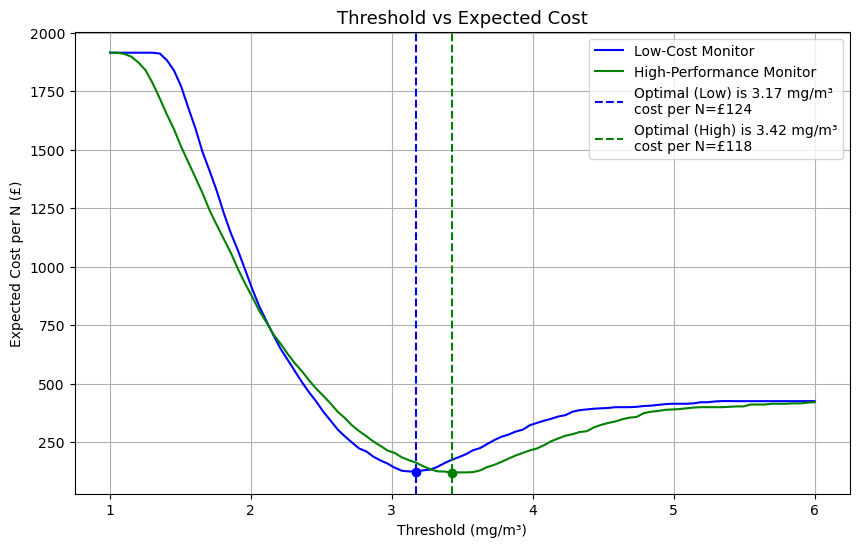

In [15]:
#The code and formula for expected cost are adapted from logistic_regression2 notebook [7]

from sklearn.model_selection import cross_val_predict

low_cost_model, high_perf_model = low_cost_monitor['model'], high_perf_monitor['model']
y_pred_low_cost_cross_v = cross_val_predict(low_cost_model, X_train_imputed, y_train, cv=cv)
y_pred_high_performance_cross_v = cross_val_predict(high_perf_model, X_train_imputed, y_train, cv=cv)

thresholds = np.linspace(1, 6, 100)
N = len(y_train) 

expected_cost_lcm = []
expected_cost_hpm = []

for n in thresholds:
    # Low-Cost Monitor
    alerts_lcm = (y_pred_low_cost_cross_v > n)
    FP_lcm = np.sum(alerts_lcm & (y_train <= 5))
    FN_lcm = np.sum(~alerts_lcm & (y_train > 5))
    expected_cost_per_N_lcm = (FP_lcm * 2000 + FN_lcm * 10000) / N #cost function adapted from logistic_regression2 notebook
    expected_cost_lcm.append(expected_cost_per_N_lcm)
    
    # High-Performance Monitor
    alerts_hpm = (y_pred_high_performance_cross_v > n)
    FP_hpm = np.sum(alerts_hpm & (y_train <= 5))
    FN_hpm = np.sum(~alerts_hpm & (y_train > 5))
    expected_cost_per_N_hpm = (FP_hpm * 2000 + FN_hpm * 10000) / N
    expected_cost_hpm.append(expected_cost_per_N_hpm)

optimal_t_lcm, optimal_t_hpm = thresholds[np.argmin(expected_cost_lcm)], thresholds[np.argmin(expected_cost_hpm)]
min_cost_lcm, min_cost_hpm = min(expected_cost_lcm), min(expected_cost_hpm)

# Plot cost curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, expected_cost_lcm, label='Low-Cost Monitor', color='blue')
plt.plot(thresholds, expected_cost_hpm, label='High-Performance Monitor', color='green')

# Optimal thresholds
plt.axvline(optimal_t_lcm, color='blue', ls='--', label=f'Optimal (Low) is {optimal_t_lcm:.2f} mg/m³\ncost per N=£{min_cost_lcm:,.0f}')
plt.axvline(optimal_t_hpm, color='green', ls='--', label=f'Optimal (High) is {optimal_t_hpm:.2f} mg/m³\ncost per N=£{min_cost_hpm:,.0f}')

# Mark the points
plt.scatter([optimal_t_lcm], [min_cost_lcm], color='blue')
plt.scatter([optimal_t_hpm], [min_cost_hpm], color='green')
plt.xlabel('Threshold (mg/m³)', fontsize=10)
plt.ylabel('Expected Cost per N (£)', fontsize=10)
plt.title('Threshold vs Expected Cost', fontsize=13)
plt.legend()
plt.grid(True)
plt.show()

#### PART J

Compare the difference between the low-cost and high-performance monitor expected cost. Discuss the relative differences and add a remark whether added sensors justify the cost reduction.

After looking on the expected cost using the cross validation, it's fairly recommended to add the sensors since there's a difference in cost per sample (N) between low performance monitor (£124/N) at threshold (3.17 mg/m3) and High performing one (£118/N) at threshold (3.42 mg/m3). Therefore, we recommend to use the high performance monitor with initial capital investment of £3500 to purchase PT08.S1(CO) and C6H6(GT) sensor, this design have better accuracy with r-squared at 0.6947 and RMSE at 0.824.

# Question 2 Background

The UK National Cyber Security Centre (NCSC) is required to detect malicious traffic on the web-based national infrastructure. One method is to create a statistic model of the network traffic and the cyber operators observe diverse network statistics over time and spot the anomaly patterns and flag them for further investigation.

False negatives (missed attacks) are expensive and false positives are time wasting. Assume the expected cost of a False Negative is £1,000,000 while the cost of a False Positive is FP=£1,000.

## Business Objective

1. Develop effective models for classifying the a potential malicious internet traffic.
2. Based from models, find best decision threshold to minimise the expected cost.

## Dataset Description
We will use real network traffic data which contains flow- level records of benign traffic and multiple types of DDoS (Distributed Denial of Service) attacks. A summary of the variables is shown below:

| Name | Type |
|------|------|
| Flow Duration | Continuous |
| Total Fwd Packets | Continuous |
| Total Backward packets | Continuous |
| Total length of Fwd packets | Continuous |
| Total length of Bwd packets | Continuous |
| Flow IAT mean | Continuous |
| Flow IAT std | Continuous |
| Packet Length mean | Continuous |
| Packet length Std | Continuous |
| Average Packet Size | Continuous |
| Active Mean | Continuous |
| Idle Mean | Continuous |
| Protocol | Categorical (6, 17, 0) |
| Target | 1/0 |

#### PART A

Load the data in python, create a class balance report and plot the distribution features of Flow Duration and Total Fwd Packets for benign vs attack flows. Additionally, report two insights regarding separation between classes.

In [ ]:
#Load the data (Part A 1.1)
cyber_data = pd.read_csv('~/Machine Learning/Assignment 2025/cyber_data/q2.csv')
print(cyber_data.shape[0])
cyber_data.head(3)

10000


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow IAT Mean,Flow IAT Std,Packet Length Mean,Packet Length Std,Average Packet Size,Active Mean,Idle Mean,Protocol,target
0,2,2,0,12.0,0.0,2.000000,0.000000,6.0,0.0,9.0,0.0,0.0,6,0
1,101,2,2,12.0,12.0,33.666667,56.580326,6.0,0.0,7.5,0.0,0.0,6,1
2,1,2,0,12.0,0.0,1.000000,0.000000,6.0,0.0,9.0,0.0,0.0,6,1


In [18]:
#check data with missing values in all features just in case
cyber_features = cyber_data.columns.drop('target').tolist()
cyber_data[cyber_data[cyber_features].isnull().all(axis=1)]

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow IAT Mean,Flow IAT Std,Packet Length Mean,Packet Length Std,Average Packet Size,Active Mean,Idle Mean,Protocol,target


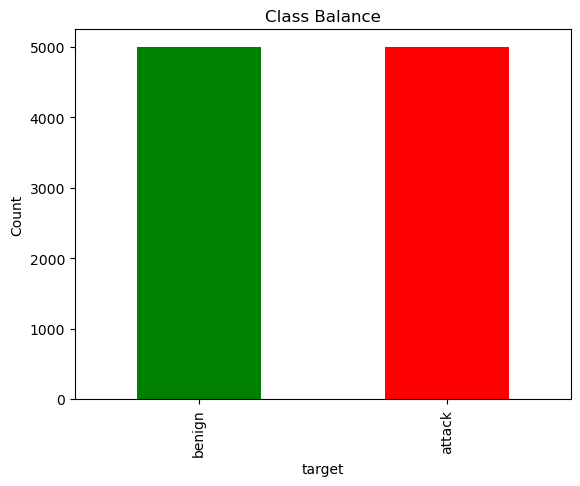

In [19]:
#the code below is referenced from worksheet 4 [6]

#Class balance (Part A 1.2)
counts = cyber_data['target'].value_counts().rename(index={0: "benign", 1: "attack"})
counts.plot.bar(title="Class Balance", color=['green', 'red'])
plt.ylabel("Count"); plt.show()

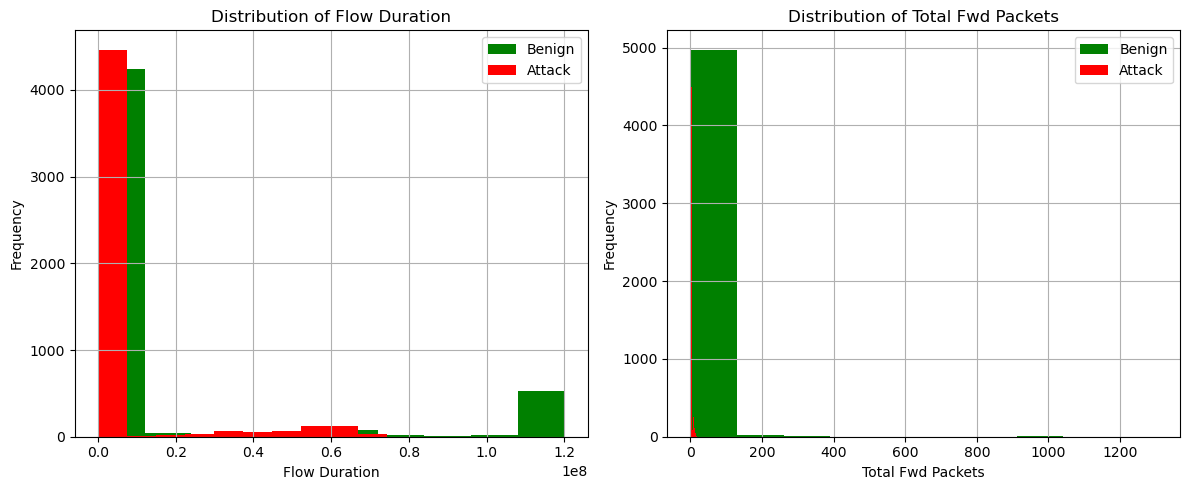

In [20]:
#plot using histogram

# Distribution features (Part A 1.3)
plt.figure(figsize=(12, 5))

#Flow duration hist
plt.subplot(1, 2, 1)
cyber_data[cyber_data['target'] == 0]['Flow Duration'].hist(label='Benign',color='green')
cyber_data[cyber_data['target'] == 1]['Flow Duration'].hist(label='Attack',color='red')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Flow Duration')

#Total Fwd Packet hist
plt.subplot(1, 2, 2)
cyber_data[cyber_data['target'] == 0]['Total Fwd Packets'].hist(label='Benign',color='green')
cyber_data[cyber_data['target'] == 1]['Total Fwd Packets'].hist(label='Attack',color='red')
plt.xlabel('Total Fwd Packets')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Total Fwd Packets')
plt.tight_layout()
plt.show()

In [20]:
#the data is very skewed, we need to check the skewness first
skewness = cyber_data.drop(['target', 'Protocol'], axis=1).skew()
print(skewness.sort_values(ascending=False))

Total Length of Bwd Packets    36.783983
Total Backward Packets         31.403323
Total Fwd Packets              26.873864
Total Length of Fwd Packets    13.751304
Active Mean                    12.218540
Packet Length Mean              5.493914
Average Packet Size             5.409536
Flow IAT Mean                   5.300928
Idle Mean                       4.346157
Flow IAT Std                    4.201328
Packet Length Std               3.936260
Flow Duration                   2.918787
dtype: float64


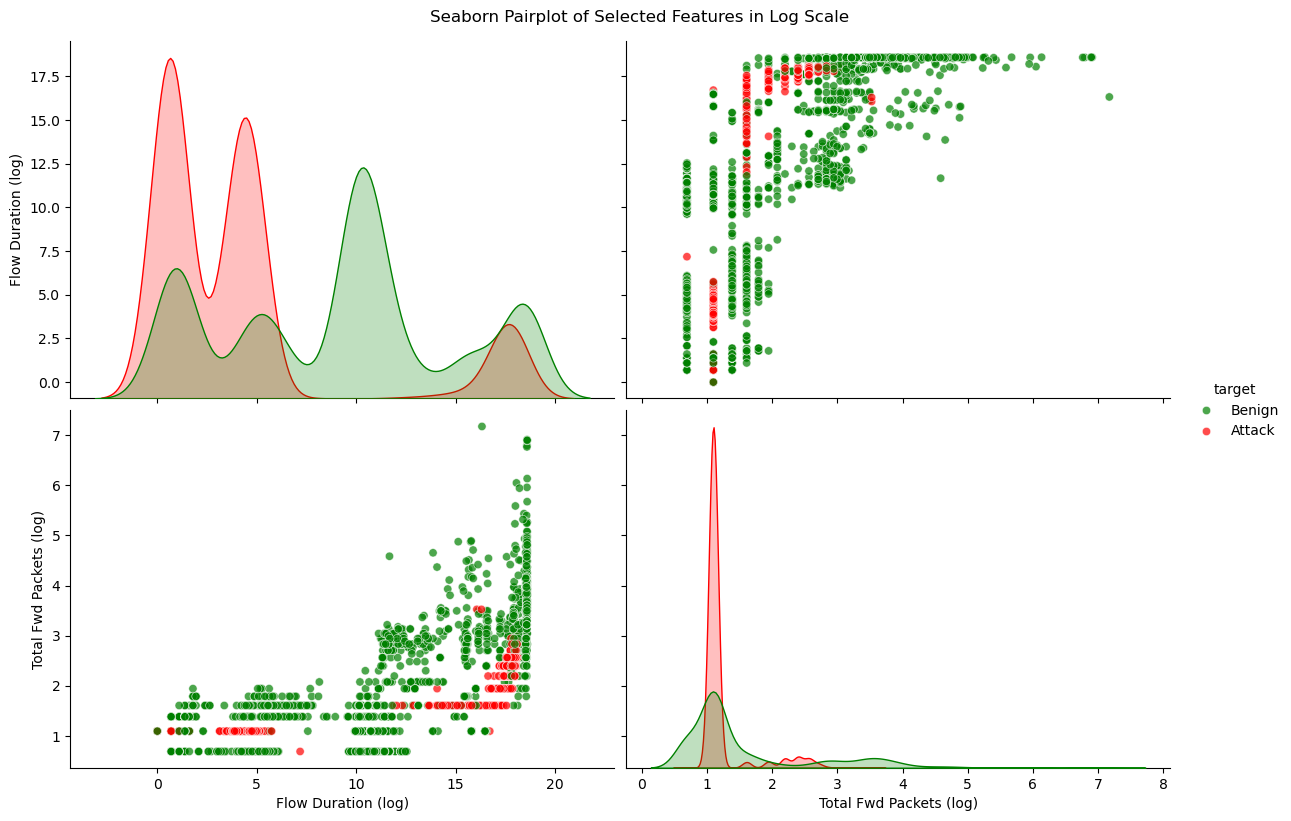

In [21]:
#the code below is referenced from worksheet4 [8]

# Distribution features (Part A 1.3)
# this one use pair plot

#since the data is highly skewed for Total Fwd Packets and quite skewed for Flow Duration, using log transform might help
X = cyber_data.drop('target', axis=1)
y = cyber_data['target']

X_log = X[["Flow Duration", "Total Fwd Packets"]].copy()
X_log['Flow Duration (log)'] = np.log1p(X_log['Flow Duration'])
X_log['Total Fwd Packets (log)'] = np.log1p(X_log['Total Fwd Packets'])

selected_features = ["Flow Duration (log)", "Total Fwd Packets (log)"]
y_labeled = y.map({0: 'Benign', 1: 'Attack'})
plot_data = pd.concat([X_log[selected_features], y_labeled.rename("target")], axis=1)

sns.pairplot(
    data=plot_data,
    hue="target",
    palette={'Benign': 'green', 'Attack': 'red'},
    diag_kind="kde",
    plot_kws={"alpha": 0.7},
    height=4,
    aspect=1.5 
)

plt.suptitle("Seaborn Pairplot of Selected Features in Log Scale", y=1.02)
plt.show()

<ins>Report insights (Part A 1.4)<ins>
* From the log transformed plot, we can observe that it's quite difficult to separate and classify between benign and malicious attack since the Total Fwd Packets versus Flow Duration in a two-dimensional perspective looks like it's not linearly separable.
* Looking at the Flow Duration independently, attack patterns are dominated by short flow durations however some attacks shows similar durations to benign flows which makes them difficult to distinguish. For Total Fwd Packets, we can assume connections with values above log(3) are classified as benign, while values below log(3) contain both classes which means it is difficult to separate using this feature alone.

#### PART B

Fit a logistic regression model, plot a confusion matrix and report the accuracy, and ROC, ROC-AUC and make remarks on their interpretation.

RESULTS
Accuracy: 0.9545
ROC-AUC: 0.9755


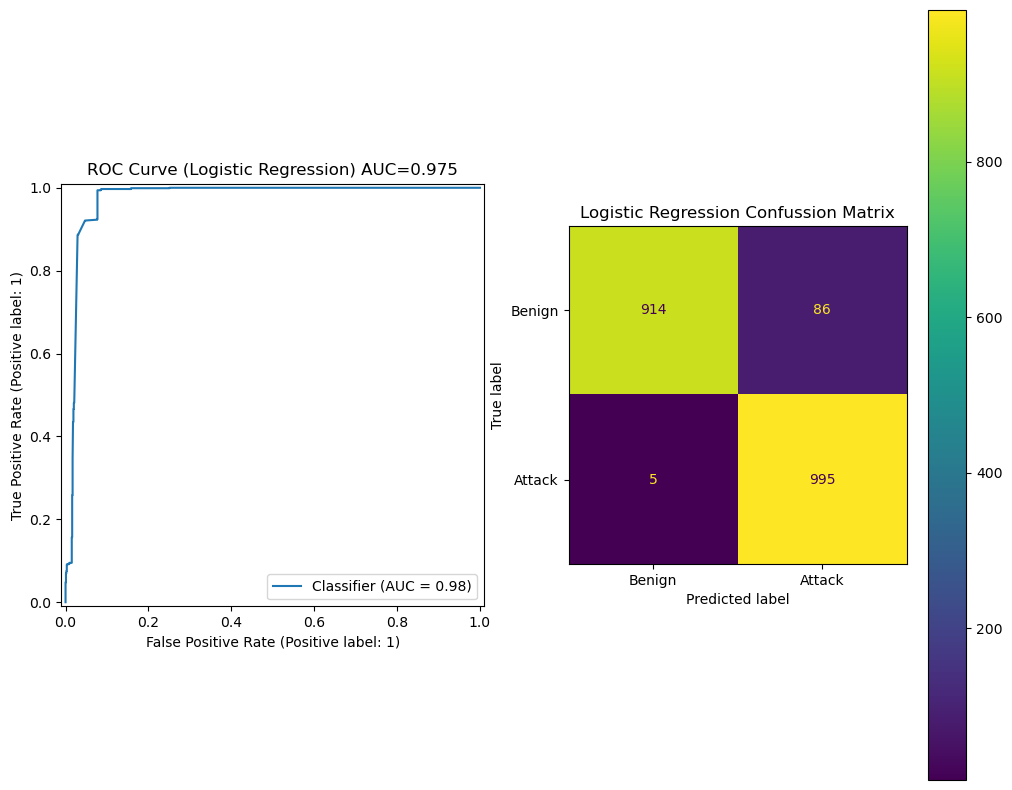

In [22]:
#the code below is referenced from workbook 4 [8]

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.metrics import accuracy_score, roc_auc_score

#Since we already know that most of our features are skewed, it's better to do log transformation before scaling
cyber_features_without_protocol = cyber_data.columns.drop(['target','Protocol']).tolist()
X_log = X.copy()

for feature in cyber_features_without_protocol:
    X_log[feature] = np.log1p(X[feature])

# Create and fit with OneHotEncoder
# OneHotEncoder docs can be found here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
protocol = X_log[['Protocol']]
encoder = OneHotEncoder(sparse_output=False)
protocol_encoded = encoder.fit_transform(protocol)

# Convert to DataFrame with column names
protocol_df = pd.DataFrame(protocol_encoded, columns=['Protocol_0', 'Protocol_6', 'Protocol_17'], index=X.index)

# Drop original Protocol column and add new encoded columns
X_encoded = X_log.drop('Protocol', axis=1)
X_encoded = pd.concat([X_encoded, protocol_df], axis=1)

#split data 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Pipelining just like workbook4
pipe_LR = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42)),
])

pipe_LR.fit(X_train, y_train)

#modified with axes so it can save spaces
def evaluate_prob_plots(pipe, label, ax):
    y_score = pipe.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_score)
#    ap = average_precision_score(y_test, y_score) turning off precision score from workbook because it's not asked

    RocCurveDisplay.from_predictions(y_test, y_score, ax=ax)
    ax.set_title(f"ROC Curve ({label}) AUC={roc_auc:.3f}")
#    plt.title(f"ROC Curve ({label}) AUC={roc_auc:.3f}"); plt.show()

#    PrecisionRecallDisplay.from_predictions(y_test, y_score)
#    plt.title(f"PR Curve ({label}) AP={ap:.3f}"); plt.show()

# Predictions
y_pred_LR, y_prob_LR = pipe_LR.predict(X_test), pipe_LR.predict_proba(X_test)[:, 1]
accuracy_LR = accuracy_score(y_test, y_pred_LR)
roc_auc_LR = roc_auc_score(y_test, y_prob_LR)

cm = confusion_matrix(y_test, y_pred_LR)

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
evaluate_prob_plots(pipe_LR, "Logistic Regression", axes[0])
ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Attack']).plot(values_format="d", ax=axes[1])
plt.title(f"Logistic Regression Confussion Matrix")

print("RESULTS")
print(f"Accuracy: {accuracy_LR:.4f}")
print(f"ROC-AUC: {roc_auc_LR:.4f}")

<ins>Part B 1.4<ins>
    
As we can see, logistic regression model has an accuracy 95.5% on the test set which technically quite good number wise, but getting 5 False Negatives (FN) means that we will need to pay around 7,000,000. A threshold optimisation might be needed to reduce the FN number to zero.

From the ROC-AUC perpective, this model separates benign and attack traffic very well, since 0.9755 means the model have 97.55% chance to assign the data to its correct class.

#### PART C

C. Penalised logistic regression

Fit an L1-regularised logistic regression. Report the accuracy and ROC and ROC-AUC. Perform 20 bootstrap resamples of the data and plot how often each feature is selected by measuring the proportion of resamples in which the feature is selected. Visualise and interpret the top 5 most influential features (largest absolute coefficients). Comment briefly (2–3 sentences) on what these imply about benign vs malicious traffic.

L1-REGULARIZED LOGISTIC REGRESSION RESULTS

Best C parameter: 100
Best CV Accuracy: 0.9886
Accuracy: 0.9575
ROC-AUC: 0.9899


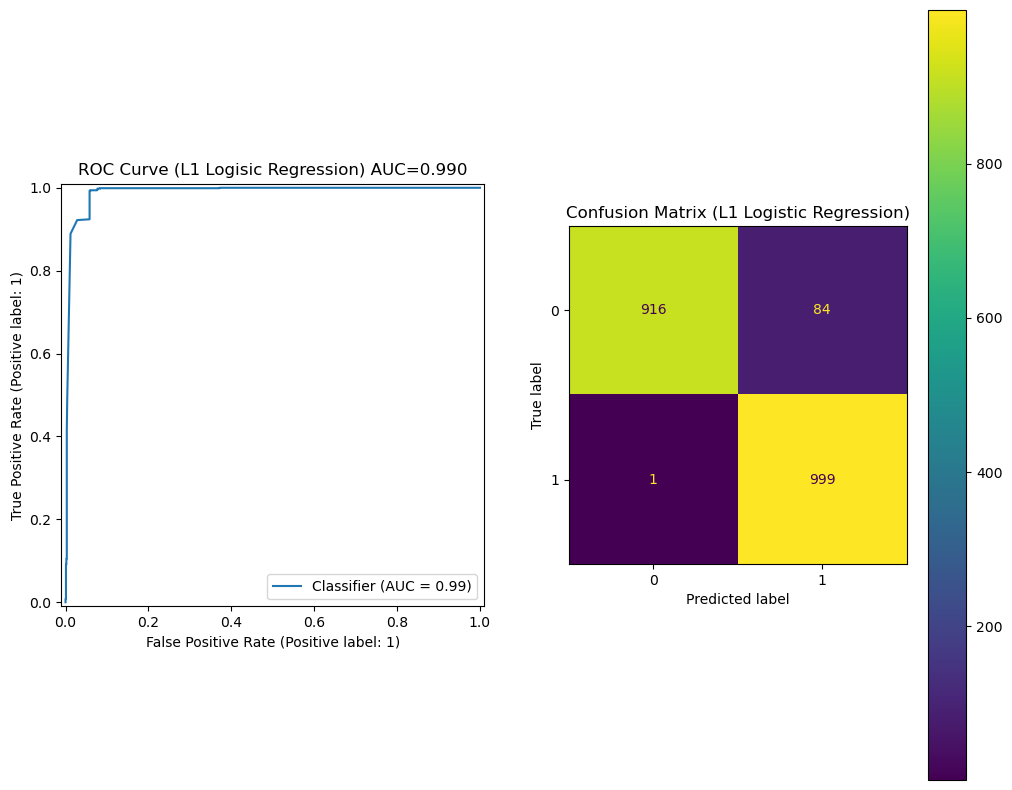

In [25]:
#the code below is referenced from worksheet 4 [8]

feature_names = X_encoded.columns.tolist()

pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )),
])

#using gridsearch so that the model get the best value using optimum C
param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

#Grid search pipeline
grid_l1 = GridSearchCV(
    estimator=pipe_l1,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

grid_l1.fit(X_train, y_train)
#best C
model_l1 = grid_l1.best_estimator_
#get prediction and score
y_pred_l1 = model_l1.predict(X_test)
y_prob_l1 = model_l1.predict_proba(X_test)[:, 1]

accuracy_l1 = accuracy_score(y_test, y_pred_l1)
roc_auc_l1 = roc_auc_score(y_test, y_prob_l1)

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
evaluate_prob_plots(model_l1, "L1 Logisic Regression", axes[0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_l1, values_format="d", ax=axes[1])
axes[1].set_title('Confusion Matrix (L1 Logistic Regression)')

print("L1-REGULARIZED LOGISTIC REGRESSION RESULTS")
print(f"\nBest C parameter: {grid_l1.best_params_['clf__C']}")
print(f"Best CV Accuracy: {grid_l1.best_score_:.4f}")
print(f"Accuracy: {accuracy_l1:.4f}")
print(f"ROC-AUC: {roc_auc_l1:.4f}")

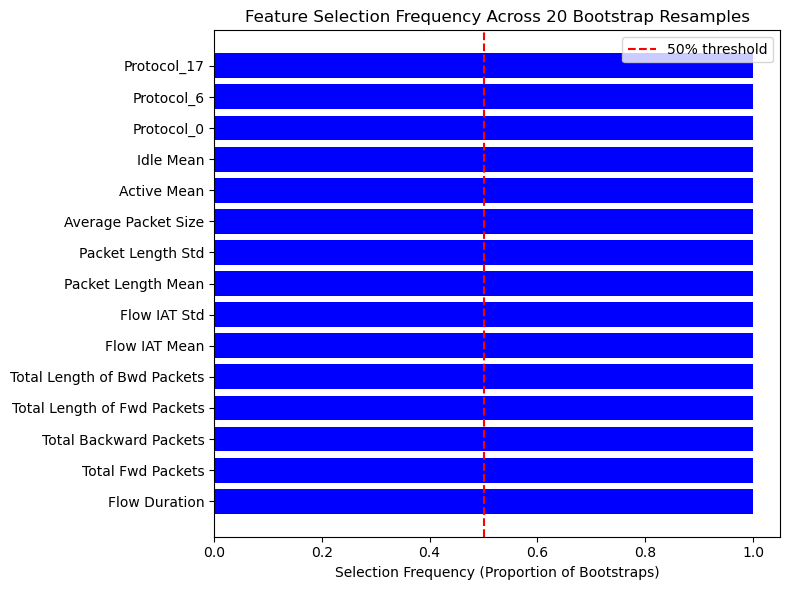

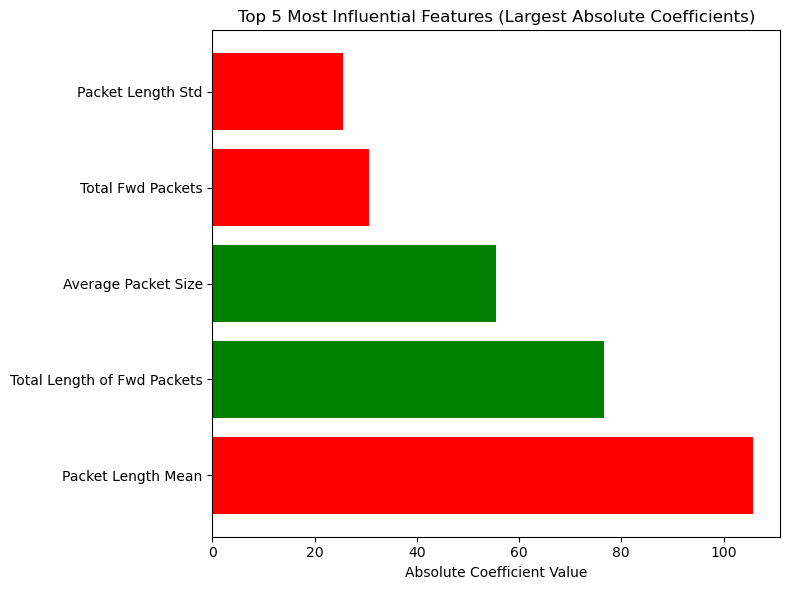

,Feature,Coefficient
0,Packet Length Mean,-105.753620
1,Total Length of Fwd Packets,76.571397
2,Average Packet Size,55.425047
3,Total Fwd Packets,-30.717276
4,Packet Length Std,-25.522841


In [26]:
#Bootstrapping
#scikitlearn has this resample library to complement bootstrapping
#docs can be found here https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html [9]
from sklearn.utils import resample

n_bootstrap = 20
feature_selection_counts = np.zeros(len(feature_names))

for i in range(n_bootstrap):
    # Resample training data with replacement
    X_bootstrap, y_bootstrap = resample(X_train, y_train)

    pipe_bootstrap = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty='l1',
            solver='liblinear',
            C=grid_l1.best_params_['clf__C'], #optimum C from previous code run
            max_iter=1000,
            random_state=42
        )),
    ])
    
    pipe_bootstrap.fit(X_bootstrap, y_bootstrap)
    model_bootstrap = pipe_bootstrap.named_steps['clf']
    # Count which features were selected (non-zero coefficient)
    selected_feature = (model_bootstrap.coef_[0] != 0).astype(int)
    feature_selection_counts += selected_feature

# Calculate selection proportion
selection_proportion = feature_selection_counts / n_bootstrap

#get best model
model_l1 = grid_l1.best_estimator_.named_steps['clf']

# Create DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Selection_Frequency': selection_proportion,
    'Coefficient': model_l1.coef_[0]
}).sort_values('Selection_Frequency', ascending=False)

# Plot feature selection frequency
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), feature_importance_df['Selection_Frequency'], color='blue')
plt.yticks(range(len(feature_names)), feature_importance_df['Feature'])
plt.xlabel('Selection Frequency (Proportion of Bootstraps)')
plt.title('Feature Selection Frequency Across 20 Bootstrap Resamples')
plt.axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
top_5_features = feature_importance_df.nlargest(5, 'Abs_Coefficient')

plt.figure(figsize=(8, 6))

colors = ['red' if c < 0 else 'green' for c in top_5_features['Coefficient']]
plt.barh(range(5), top_5_features['Abs_Coefficient'], color=colors) 
plt.yticks(range(5), top_5_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 5 Most Influential Features (Largest Absolute Coefficients)')
plt.tight_layout()
plt.show()

top_5_df = pd.DataFrame({
    "Feature": top_5_features["Feature"],
    "Coefficient": top_5_features["Coefficient"]})

top_5_df.reset_index(drop=True)

After bootstraping 20 times, we can see every feature has a selection frequency of 1.0, which means the L1-regularised model keeps the features to non-zero across all 20 bootstrap session (due to optimum C is 100 which is quite high). Out of all of the features, Packet Length Mean has the largest negative coefficient which means it is strongly reduce the predicted probability of an attack, while Total Length of Fwd Packets and Average Packet Size have large positive coefficients which increase attack probability. Total Fwd Packets and Packet Length Std also have moderate negative coefficients which reduce attack probability but not as high as Packet Length Mean.

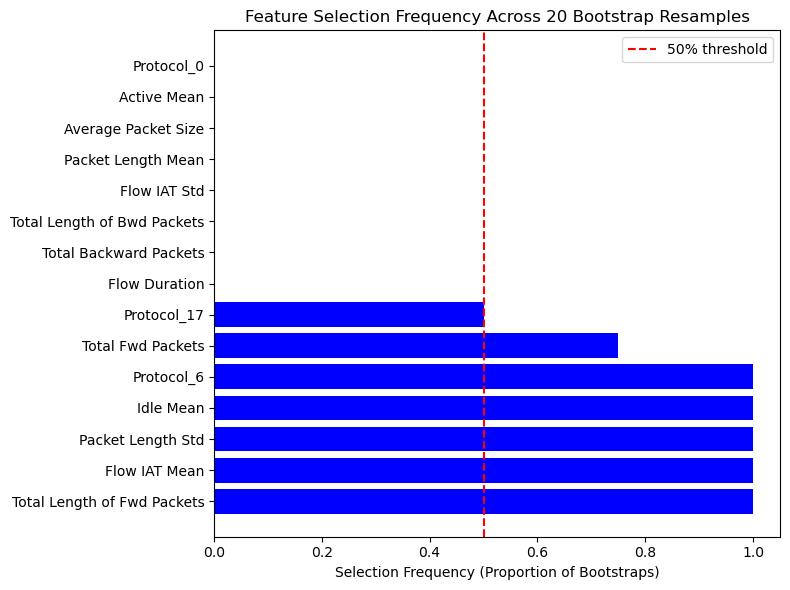

In [44]:
#This is an extra iteration, if I choose lower C for the L1 logistic regression the sparsity will show up
#Lower C means it will allow L1 to drag some features down to zero due to high penalty, thus allowing a feature selection
#previous iteration was set as param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#For the subsequent question, I'll still use the above result.

param_grid = {"clf__C": [0.0001, 0.001, 0.01]}

grid_l1 = GridSearchCV(
    estimator=pipe_l1,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

grid_l1.fit(X_train, y_train)
#best C
model_l1 = grid_l1.best_estimator_
#get prediction and score
y_pred_l1 = model_l1.predict(X_test)
y_prob_l1 = model_l1.predict_proba(X_test)[:, 1]

n_bootstrap = 20
feature_selection_counts = np.zeros(len(feature_names))

for i in range(n_bootstrap):
    # Resample training data with replacement
    X_bootstrap, y_bootstrap = resample(X_train, y_train)

    pipe_bootstrap = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty='l1',
            solver='liblinear',
            C=grid_l1.best_params_['clf__C'], #optimum C from previous code run
            max_iter=1000,
            random_state=42
        )),
    ])
    
    pipe_bootstrap.fit(X_bootstrap, y_bootstrap)
    model_bootstrap = pipe_bootstrap.named_steps['clf']
    # Count which features were selected (non-zero coefficient)
    selected_feature = (model_bootstrap.coef_[0] != 0).astype(int)
    feature_selection_counts += selected_feature

# Calculate selection proportion
selection_proportion = feature_selection_counts / n_bootstrap

#get best model
model_l1 = grid_l1.best_estimator_.named_steps['clf']

# Create DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Selection_Frequency': selection_proportion,
    'Coefficient': model_l1.coef_[0]
}).sort_values('Selection_Frequency', ascending=False)

# Plot feature selection frequency
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), feature_importance_df['Selection_Frequency'], color='blue')
plt.yticks(range(len(feature_names)), feature_importance_df['Feature'])
plt.xlabel('Selection Frequency (Proportion of Bootstraps)')
plt.title('Feature Selection Frequency Across 20 Bootstrap Resamples')
plt.axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

#### PART D

D. Linear SVM

Fit Linear SVM with both hard and soft margins. In the soft-margin case, the regularisation parameter 𝐶 should be tuned by CV using grid search over 𝐶 ∈ { 0.1, 1, 10, 100 }. For each model:
* Report the accuracy, ROC-AUC, as well as the number of support vectors.
* Plot decision boundary in a 2D projection (choose two continuous features).
* Explain why hard margin SVM is fragile in this context.

In [27]:
#the code below is referenced from worksheet 4 [8]
#For linear SVC problem, it's better to split the codeblock for debugging
from sklearn.svm import SVC
#added set to ignore warnings because setting max_iter can trigger pandas warning if it's not converging yet
import warnings
warnings.filterwarnings("ignore")

#decides to config C as 1000000 and add max_iter 5000000 due to my limited resource
pipe_hard_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel='linear', C=1000000, probability=True, random_state=42, max_iter=500000)),
]).fit(X_train, y_train)

y_pred_hard_svm, y_score_hard_svm = pipe_hard_svm.predict(X_test), pipe_hard_svm.decision_function(X_test)

In [28]:
#the code below is referenced from worksheet 4 [8]

#the SVC has O(n2) complexity, better to limit the max iteration or it will run forever
# SOFT MARGIN SVM with Grid Search 
param_grid = {'svc__C': [0.1, 1, 10, 100]}

soft_svm = GridSearchCV(
    Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel='linear', random_state=42, probability=True, cache_size=2000, max_iter=200000))
    ]),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
).fit(X_train, y_train)

y_pred_soft, y_score_soft = soft_svm.predict(X_test), soft_svm.decision_function(X_test)

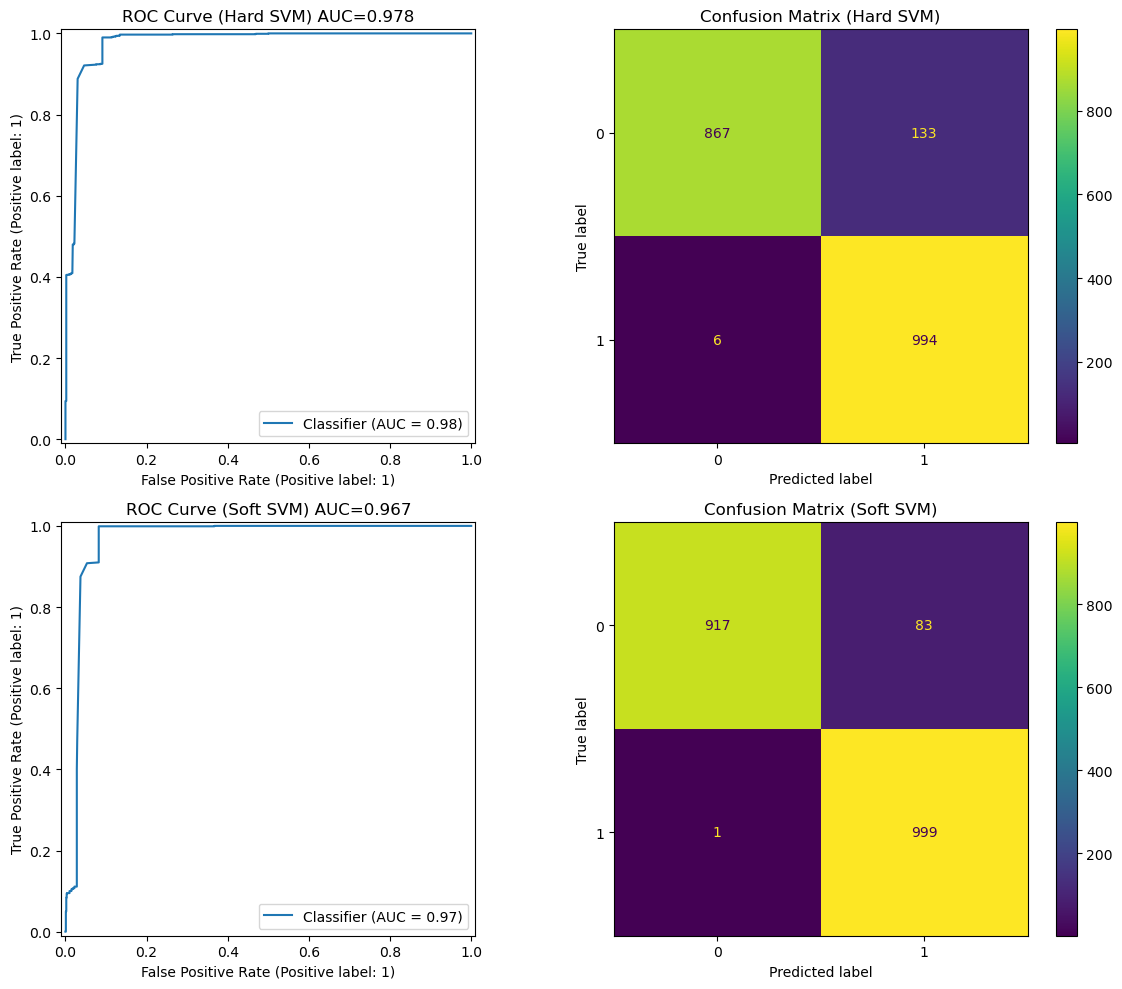

HARD SVM RESULTS
Accuracy: 0.9305
ROC-AUC: 0.9779
Support vectors: 435
----------------
SOFT SVM RESULTS
Accuracy: 0.9580
ROC-AUC: 0.9669
Support vectors: 794


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

evaluate_prob_plots(pipe_hard_svm, "Hard SVM", axes[0, 0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hard_svm, ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix (Hard SVM)")

evaluate_prob_plots(soft_svm, "Soft SVM", axes[1, 0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_soft, ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix (Soft SVM)")
plt.tight_layout()
plt.show()

accuracy_hard_svm = accuracy_score(y_test, y_pred_hard_svm)
roc_auc_hard_svm = roc_auc_score(y_test, y_score_hard_svm)

accuracy_soft_svm = accuracy_score(y_test, y_pred_soft)
roc_auc_soft_svm = roc_auc_score(y_test, y_score_soft)

print("HARD SVM RESULTS")
print(f"Accuracy: {accuracy_hard_svm:.4f}")
print(f"ROC-AUC: {roc_auc_hard_svm:.4f}")
print(f"Support vectors: {pipe_hard_svm.named_steps["svc"].support_vectors_.shape[0]}")
print("----------------")
print("SOFT SVM RESULTS")
print(f"Accuracy: {accuracy_soft_svm:.4f}")
print(f"ROC-AUC: {roc_auc_soft_svm:.4f}")
print(f"Support vectors: {soft_svm.best_estimator_.named_steps["svc"].support_vectors_.shape[0]}")

In [30]:
#The code below is adapted from logistic regression 1 notebook [10]

#For plotting decision plot in 2D I choose these features since both have large absolute coefficient
feature_1 = 'Packet Length Mean'
feature_2 = 'Total Length of Fwd Packets'

#Get the 2D array of the selected features
X_train_2d = X_train[[feature_1, feature_2]].values
X_test_2d = X_test[[feature_1, feature_2]].values

pipe_hard_svm_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel='linear', C=1000000, probability=True, random_state=42, max_iter=500000)),
]).fit(X_train_2d, y_train)

pipe_soft_svm_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel='linear', C=soft_svm.best_params_['svc__C'], probability=True, cache_size=2000, max_iter=200000))
]).fit(X_train_2d, y_train)

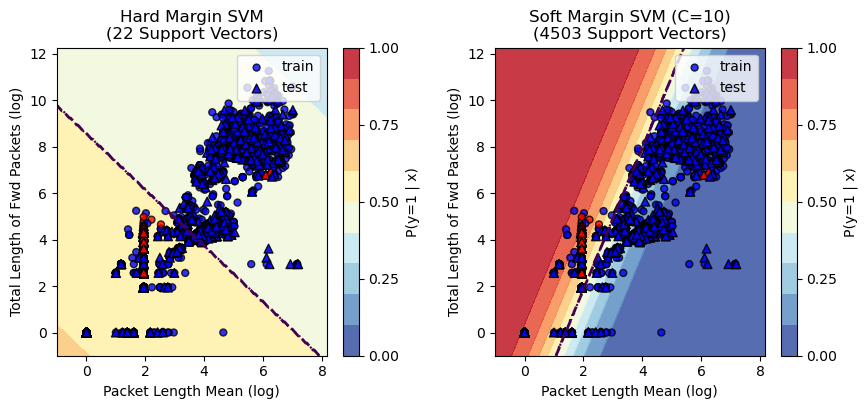

In [31]:
# grid adapted from logistic regression 1 notebook [10]
def desbon(model, X_train, y_train, X_test, y_test, ax, fig, feature_1, feature_2, title, 
                               threshold=0.5, n_support=None):
    x1min, x1max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2min, x2max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.linspace(x1min, x1max, 220),
        np.linspace(x2min, x2max, 220)
    )
    mesh_points = np.c_[xx1.ravel(), xx2.ravel()]
    Z = model.predict_proba(mesh_points)[:, 1].reshape(xx1.shape)
    
    # Filled contour for probability field
    cs = ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1, 11), 
                     cmap='RdYlBu_r', alpha=0.85)
    cb = fig.colorbar(cs, ax=ax, ticks=[0, 0.25, 0.5, 0.75, 1.0])
    cb.set_label("P(y=1 | x)")

    ax.contour(xx1, xx2, Z, levels=[0.5], linestyles="--", linewidths=2)
    ax.contour(xx1, xx2, Z, levels=[threshold], linestyles=":", linewidths=1.5)
    
    # Points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="bwr", 
               edgecolors="k", s=25, alpha=0.8, label="train")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="bwr", 
               edgecolors="k", s=40, marker="^", alpha=0.9, label="test")
    
    ax.set_xlabel(feature_1)
    ax.set_ylabel(feature_2)
    ax.set_title(title)
    ax.legend(loc="upper right")

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, wspace=0.3)

axA = fig.add_subplot(gs[0, 0])
desbon(pipe_hard_svm_2d, X_train_2d, y_train, X_test_2d, y_test,
       axA, fig, feature_1=f'{feature_1} (log)', feature_2=f'{feature_2} (log)',
       title=f'Hard Margin SVM\n({len(pipe_hard_svm_2d.named_steps["svc"].support_vectors_)} Support Vectors)')

axB = fig.add_subplot(gs[0, 1])
desbon(pipe_soft_svm_2d, X_train_2d, y_train, X_test_2d, y_test, 
       axB, fig, feature_1=f'{feature_1} (log)', feature_2=f'{feature_2} (log)',
       title=f"Soft Margin SVM (C={soft_svm.best_params_['svc__C']})\n({len(pipe_soft_svm_2d.named_steps['svc'].support_vectors_)} Support Vectors)")

plt.tight_layout()
plt.show()

Hard SVM is quite fragile to data with outliers and non linear ones, from the graph it can be seen that benign and attack points mix together quite a lot. There isn’t a clean straight line that can perfectly separate the two colours. Since hard SVM is quite strict which demands every single training point is on the correct side of the line (unlike soft SVM), the decision boundary line sits in the middle of the class to satisfy a small number of points. In conclusion, the hard SVM is very likely to misclassify many flows since it has been tuned closely to the training data with outlier and non linear ones, thus, not very suitable for cyber traffic classification.

#### PART E

Fit an RBF-kernel SVM.
* Tune (𝐶, 𝛾) using cross-validation, using a grid search with 𝐶 ∈ { 0.1, 1, 10, 100 } and 𝛾 ∈ {0.001, 0.1, 1, 10}.
* Compare test performance to logistic regression.

Best parameters: {'svc__C': 1, 'svc__gamma': 10}
Best CV ROC-AUC: 0.9958
Best accuracy: 0.9745


Text(0.5, 1.0, 'Confusion Matrix (RBF-Kernel SVM)')

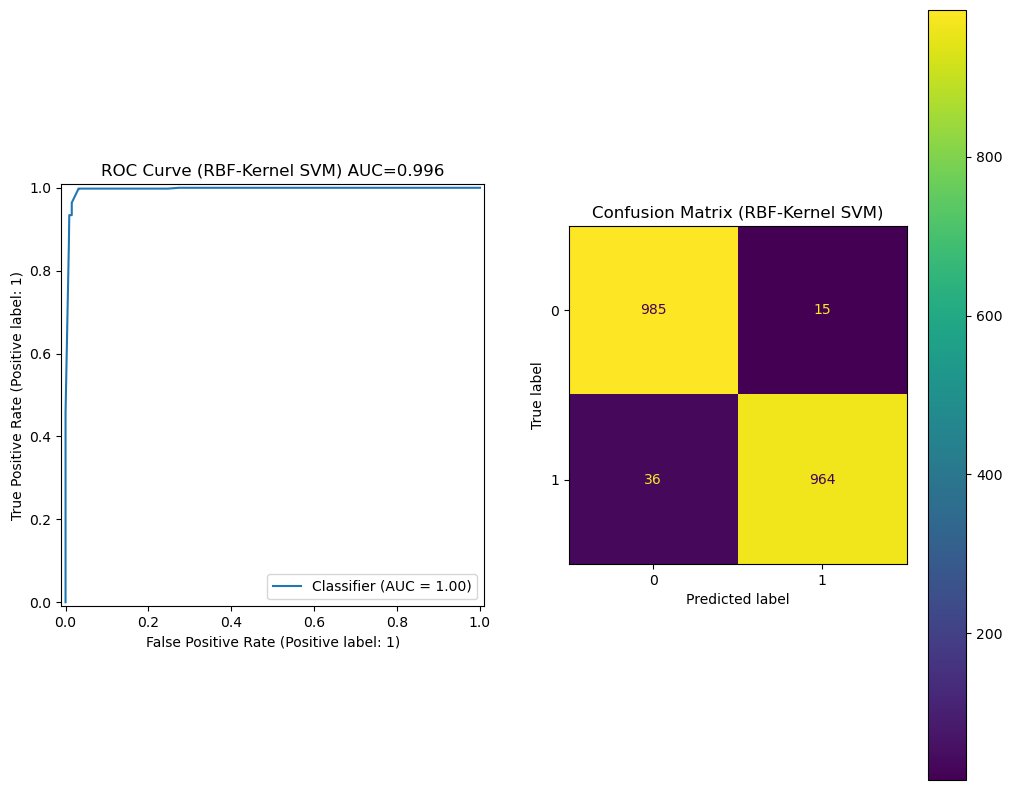

In [32]:
#the code below is referenced from worksheet 4 [8]
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import average_precision_score
from sklearn.calibration import calibration_curve

pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid = {'svc__C': [0.1, 1, 10, 100], 'svc__gamma': [0.001, 0.1, 1, 10]}

grid_search_rbf = GridSearchCV(
    estimator=pipe_rbf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1,
    return_train_score=True
).fit(X_train, y_train)

best_rbf = grid_search_rbf.best_estimator_
y_pred_rbf, y_prob_rbf = best_rbf.predict(X_test), best_rbf.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred_rbf)

accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
roc_auc_rbf = roc_auc_score(y_test, y_prob_rbf)

print(f"Best parameters: {grid_search_rbf.best_params_}")
print(f"Best CV ROC-AUC: {grid_search_rbf.best_score_:.4f}")
print(f"Best accuracy: {accuracy_rbf}")

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
evaluate_prob_plots(best_rbf, "RBF-Kernel SVM", axes[0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rbf, values_format="d", ax=axes[1])
axes[1].set_title('Confusion Matrix (RBF-Kernel SVM)')

In [33]:
#Compare performance with Logistic Regression
precision_rbf = precision_score(y_test, y_pred_rbf)
recall_rbf = recall_score(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf)
precision_LR = precision_score(y_test, y_pred_LR)
recall_LR = recall_score(y_test, y_pred_LR)
f1_LR = f1_score(y_test, y_pred_LR)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score'],
    'RBF SVM': [f'{accuracy_rbf:.4f}', f'{roc_auc_rbf:.4f}', f'{precision_rbf:.4f}',f'{recall_rbf:.4f}',f'{f1_rbf:.4f}'],
    'Logistic Regression': [f'{accuracy_LR:.4f}',f'{roc_auc_LR:.4f}',f'{precision_LR:.4f}', f'{recall_LR:.4f}', f'{f1_LR:.4f}']})

comparison_df

,Metric,RBF SVM,Logistic Regression
0,Accuracy,0.9745,0.9545
1,ROC-AUC,0.9960,0.9755
2,Precision,0.9847,0.9204
3,Recall,0.9640,0.9950
4,F1-Score,0.9742,0.9563


#### PART F

Cost-sensitive scenario.

* Evaluate and report the total expected cost using the default decision threshold for each model.
* Calibrate the decision threshold to minimise cost.
* Recalculate expected costs for all models, and compare, plotting ROC and cost curves to justify your threshold choice.

In [34]:
#Expected cost using default threshold

#Cost variables
C_FN = 1000000
C_FP = 1000

def calculate_cost(y_true, y_pred, C_FN, C_FP):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    # Cost Function
    total_cost = (FN * C_FN) + (FP * C_FP)
    return total_cost, FN, FP

models = {'Logistic Regression': y_prob_LR, 'L1 Logistic Regression': y_prob_l1, 
          'Hard SVM': y_pred_hard_svm, 'Soft SVM': y_pred_soft, 'RBF SVM': y_prob_rbf}

#report with dataframe
results = []
default_costs = {}
for model, y_scores in models.items():
    y_pred_default = (y_scores >= 0.5).astype(int)
    cost, FN, FP = calculate_cost(y_test, y_pred_default, C_FN, C_FP)
    default_costs[model] = cost
    results.append({
        'Model': model,
        'False Negatives': FN,
        'False Positives': FP,
        'FN Cost (£)': FN * C_FN,
        'FP Cost (£)': FP * C_FP,
        'Total Expected Cost (£)': cost
    })

default_t_comparison = pd.DataFrame(results)

print("Expected Cost with default Threshold (t = 0.5)")
print("-"*45)
default_t_comparison

Expected Cost with default Threshold (t = 0.5)
---------------------------------------------


,Model,False Negatives,False Positives,FN Cost (£),FP Cost (£),Total Expected Cost (£)
0,Logistic Regression,5,86,5000000,86000,5086000
1,L1 Logistic Regression,1,84,1000000,84000,1084000
2,Hard SVM,6,133,6000000,133000,6133000
3,Soft SVM,1,83,1000000,83000,1083000
4,RBF SVM,36,15,36000000,15000,36015000


In [40]:
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, RocCurveDisplay, PrecisionRecallDisplay)

def optimal_threshold(y_true, y_scores, C_FN, C_FP):
    # ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Positive and negative samples
    N_pos = np.sum(y_true == 1)
    N_neg = np.sum(y_true == 0)

    #cost function
    costs = C_FN * (1 - tpr) * N_pos + C_FP * fpr * N_neg

    optimal_index = np.argmin(costs)
    optimal_threshold = thresholds[optimal_index]
    optimal_cost = costs[optimal_index]
    optimal_tpr = tpr[optimal_index]
    optimal_fpr = fpr[optimal_index]

    return {
        'threshold': optimal_threshold,
        'cost': optimal_cost,
        'tpr': optimal_tpr,
        'fpr': optimal_fpr,
        'all_costs': costs,
        'all_thresholds': thresholds,
        'all_tpr': tpr,
        'all_fpr': fpr
    }
    
optimal_results_list = []
optimal_results_dict = {}

for name, y_scores in models.items():
    result = optimal_threshold(y_test, y_scores, C_FN, C_FP)
    optimal_results_dict[name] = result
    # Make predictions with optimal threshold
    y_pred_optimal = (y_scores >= result['threshold']).astype(int)
    cm = confusion_matrix(y_test, y_pred_optimal)
    FN_optimal = cm[1, 0]
    FP_optimal = cm[0, 1]
    
    # Append to list
    optimal_results_list.append({
        'Model': name,
        'Optimal Threshold': result['threshold'],
        'False Negatives': FN_optimal,
        'False Positives': FP_optimal,
        'FN Cost (£)': FN_optimal * C_FN,
        'FP Cost (£)': FP_optimal * C_FP,
        'Cost Reduction (£)': default_costs[name] - result['cost'],
        'Total Expected Cost (£)': result['cost']
    })

optimal_threshold_df = pd.DataFrame(optimal_results_list)
print("Optimal Thresholds for Every Model")
print("-"*70)

optimal_threshold_df

Optimal Thresholds for Every Model
----------------------------------------------------------------------


,Model,Optimal Threshold,False Negatives,False Positives,FN Cost (£),FP Cost (£),Cost Reduction (£),Total Expected Cost (£)
0,Logistic Regression,3.551451e-03,0,251,0,251000,4835000.0,251000.0
1,L1 Logistic Regression,5.997538e-15,0,372,0,372000,712000.0,372000.0
2,Hard SVM,0.000000e+00,0,1000,0,1000000,5133000.0,1000000.0
3,Soft SVM,0.000000e+00,0,1000,0,1000000,83000.0,1000000.0
4,RBF SVM,9.115215e-03,0,274,0,274000,35741000.0,274000.0


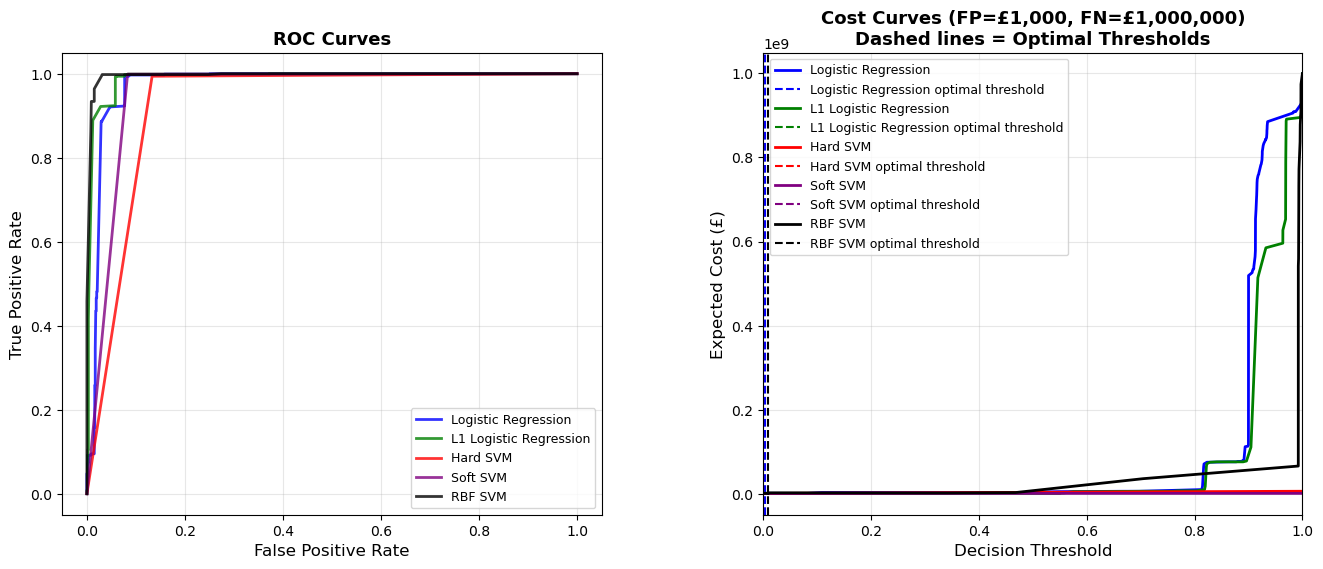

In [39]:
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, wspace=0.3)

# ROC curve
ax_roc = fig.add_subplot(gs[0, 0])

colors = ['blue', 'green', 'red', 'purple', 'black']
#loop for plotting roc
for n, (name, y_scores) in enumerate(models.items()):
    result = optimal_results_dict[name]

    ax_roc.plot(result['all_fpr'], result['all_tpr'], 
                linewidth=2, label=name, color=colors[n], alpha=0.8)

ax_roc.set_xlabel('False Positive Rate', fontsize=12)
ax_roc.set_ylabel('True Positive Rate', fontsize=12)
ax_roc.set_title('ROC Curves', fontsize=13, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=9)
ax_roc.grid(alpha=0.3)

# cost curve
ax_cost = fig.add_subplot(gs[0, 1])

for n, (name, y_scores) in enumerate(models.items()):
    result = optimal_results_dict[name]
    
    # Plot cost vs threshold
    ax_cost.plot(result['all_thresholds'], result['all_costs'], linewidth=2, color=colors[n], label=name)
    
    # vertical line for threshold
    ax_cost.axvline(result['threshold'], color=colors[n], ls='--', lw=1.5, label=f"{name} optimal threshold")

# Mark default threshold
#ax_cost.axvline(0.5, color='gray', ls=':', lw=2, alpha=0.5, label='Default t=0.5')

ax_cost.set_xlabel('Decision Threshold', fontsize=12)
ax_cost.set_ylabel('Expected Cost (£)', fontsize=12)
ax_cost.set_title(f'Cost Curves (FP=£{C_FP:,}, FN=£{C_FN:,})\nDashed lines = Optimal Thresholds', 
                  fontsize=13, fontweight='bold')
ax_cost.legend(loc='best', fontsize=9)
ax_cost.grid(alpha=0.3)
ax_cost.set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [42]:
#An extra iteration in part F
#if I train the RBF on scoring = 'accuracy', the model generates better Expected Cost
#here's the result

pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid = {'svc__C': [0.1, 1, 10, 100], 'svc__gamma': [0.001, 0.1, 1, 10]}

grid_search_rbf = GridSearchCV(
    estimator=pipe_rbf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1,
    return_train_score=True
).fit(X_train, y_train)

best_rbf = grid_search_rbf.best_estimator_
y_pred_rbf, y_prob_rbf = best_rbf.predict(X_test), best_rbf.predict_proba(X_test)[:, 1]

models = {'Logistic Regression': y_prob_LR, 'L1 Logistic Regression': y_prob_l1, 
          'Hard SVM': y_pred_hard_svm, 'Soft SVM': y_pred_soft, 'RBF SVM': y_prob_rbf}

optimal_results_list = []
optimal_results = {}


for name, y_scores in models.items():
    result = optimal_threshold(y_test, y_scores, C_FN, C_FP)
    optimal_results[name] = result
    # Make predictions with optimal threshold
    y_pred_optimal = (y_scores >= result['threshold']).astype(int)
    cm = confusion_matrix(y_test, y_pred_optimal)
    FN_optimal = cm[1, 0]
    FP_optimal = cm[0, 1]
    
    # Append to list
    optimal_results_list.append({
        'Model': name,
        'Optimal Threshold': result['threshold'],
        'False Negatives': FN_optimal,
        'False Positives': FP_optimal,
        'FN Cost (£)': FN_optimal * C_FN,
        'FP Cost (£)': FP_optimal * C_FP,
        'Cost Reduction (£)': default_costs[name] - result['cost'],
        'Total Expected Cost (£)': result['cost']
    })

optimal_threshold_df = pd.DataFrame(optimal_results_list)
print("Optimal Thresholds for Every Model")
print("-"*70)

optimal_threshold_df

Optimal Thresholds for Every Model
----------------------------------------------------------------------


,Model,Optimal Threshold,False Negatives,False Positives,FN Cost (£),FP Cost (£),Cost Reduction (£),Total Expected Cost (£)
0,Logistic Regression,3.551451e-03,0,251,0,251000,4835000.0,251000.0
1,L1 Logistic Regression,5.997538e-15,0,372,0,372000,712000.0,372000.0
2,Hard SVM,0.000000e+00,0,1000,0,1000000,5133000.0,1000000.0
3,Soft SVM,0.000000e+00,0,1000,0,1000000,83000.0,1000000.0
4,RBF SVM,1.934706e-02,0,118,0,118000,35897000.0,118000.0


#### PART G

Reflection

Present a policy briefing note for NCSC leadership:
* Compare Logistic, Penalised Logistic, Linear SVM, and Kernel SVM across: Interpretability, Accuracy, Stability under resampling, Robustness to changing costs
* Make a deployment strategy to balance between explainability and monitoring power.
* Assess risk if novel attack shift feature distribution, which model is the most vulnerable and the mitigation

# <h1><center>Policy Briefing Note for UK NCSC Leadership</center></h1>

#### Prepared by: CID 06043088

## Executive Summary
Our study on real network traffic data has come to conclusion that deploying a hybrid detection model using the RBF SVM alongside L1 Regression is the optimum way to satisfy cost efficiency with audit compliance requirements. The RBF model will act as a primary detector due to its high accuracy and L1 regression will act as the interpreter given its sparse nature.

## Model Evaluation & Comparison
Testing conducted on 10,000 network flows:

| Model | Accuracy | Interpretability | Stability Under Resampling | Robustness to Changing Costs |
|-------|----------|------------------|---------------------------|------------------------------|
| RBF SVM | Has highest ROC-AUC with 0.9960 suggesting a near perfect class separation. Also has the lowest cost (trained with scoring accuracy) with £118k | Cannot be interpreted directly which feature contributes more. | The high ROC-AUC suggests good generalization | High ROC-AUC means better threshold adjustment if the cost structures change. |
| Logistic Regression | Generally good model with £251k costs with quite high ROC at 0.9755 | The coefficients enable better reasoning for communication | Handles noisy data which tends to generalise well | A Moderate ROC-AUC means a good flexibility for threshold recalibration. |
| L1 Logistic Regression | Moderate cost at £423k. Can perform very good with ROC 0.9899 given high C at the cost of lower penalty and reduced sparsity | Technically a sparse model which can do feature selection and very ideal for explanations during audit | behave similar like standard logistic regression, with slight variation if the hyperparameter changes | Can adjust threshold but lower baseline performance will limit effectiveness. |
| Linear SVM (Hard) | This model is not justified since it cannot separate class effectively as suggested by its decision boundaries and its optimum threshold | Linear boundary less intuitive than logistic coefficients | Low to Moderate, since Hard margin is quite sensitive to outliers, its performance varies with training samples. | Not good, fragility prevents meaningful threshold optimization. |
| Linear SVM (Soft) | Just like hard SVM, linear capacity insufficient for complex patterns. | this model lacks clear feature importance measures. | It's quite robust to noise and allows constraint violations. | The results of the threshold adjustment shows this model cost is not fully robust to changing costs |

## Recommendation
Based from the facts above, I propose a hybrid deployment strategy to satisfy our 2 main important points which is cost-efficient with high accuracy and easy interpretation. To satisfy both needs, using the RBF SVM as a real-time automated detection with optimized threshold will yield great result due to its high ROC-AUC. Its low interpretability will be offset by L1 Logistic Regression, which can serve as a guide for stakeholder reporting and audit compliance

## Risk Assessment and Mitigation
RBF can learn complex nonlinear patterns tightly fitted to training data but also suggests this model is vulnerable to novel malicious attacks. To prevent such cases, we can utilise the distributions of the top 5 features identified by the L1 model as a secondary monitoring. If the coefficients changes drastically, an investigation by analyst might be needed. If an attack is confirmed, retrain the model with the new data.

# References

1. Waskom, M. 'seaborn.heatmap', Seaborn documentation (version 0.13.2). Available at: https://seaborn.pydata.org/generated/seaborn.heatmap.html (Accessed: 2 December 2025)
2. Duncan, A. (2025) Lecture 3: Our First Models. ELEC70143 - Machine Learning. Imperial College London
3. Scikit-learn developers 'sklearn.impute.KNNImputer', Scikit-learn documentation (version 1.7.2). Available at: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html (Accessed: 2 December 2025)
4. Duncan, A. (2025) worksheet1: Auto MPG Dataset: Simple Regression Models. ELEC70143 - Machine Learning. Imperial College London
5. Duncan, A. (2025) worksheet3: Diabetes Dataset: Regularised Linear Regression Analysis. ELEC70143 - Machine Learning. Imperial College London
6. Duncan, A. (2025) worksheet5: Nonlinear Regression Workbook. ELEC70143 - Machine Learning. Imperial College London
7. Duncan, A. (2025) logistic_regression2: Tuning the threshold for minimising cost. ELEC70143 - Machine Learning. Imperial College London
8. Duncan, A. (2025) worksheet4. ELEC70143 - Machine Learning. Imperial College London
9. Scikit-learn developers 'sklearn.utils.resample', Scikit-learn documentation (version 1.7.2). Available at: https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html (Accessed: 2 December 2025)
10. Duncan, A. (2025) logistic_regression1: Basic Logistic Regression Demo. ELEC70143 - Machine Learning. Imperial College London